# Moving Average Model

In [53]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import acf, pacf
from datetime import datetime, timedelta
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# Data

We will generate sample data according the following MA(2) model,

$$
X_t = 50 + 0.4 \epsilon_{t-1} + 0.3\epsilon_{t-2} + \epsilon_{t} 
$$

With $\epsilon_{t} \sim \mathcal{N}(0,1)$

In [81]:
errors = np.random.normal(0, 1, 400)

date_index = pd.date_range(start='2019-09-01', end='2020-01-01')

mu = 50

series = []

for t in range(1, len(date_index)+1):
    series.append(mu + 0.4*errors[t-1] + 0.3*errors[t-2] + errors[t])
    
series = pd.Series(data=series, index=date_index)

series = series.asfreq(pd.infer_freq(series.index))

series.head(3)

2019-09-01    51.911143
2019-09-02    51.652009
2019-09-03    49.662563
Freq: D, dtype: float64

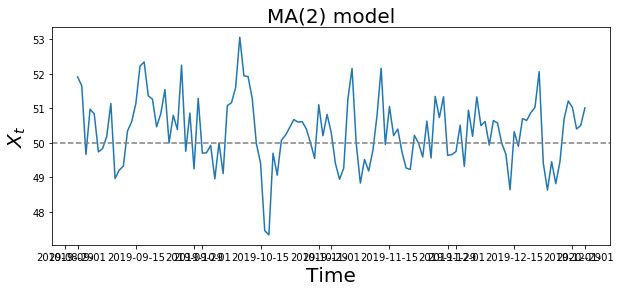

In [82]:
plt.figure(figsize=(10,4))
plt.plot(series)
plt.title('MA(2) model', fontsize=20)
plt.ylabel('$X_t$', fontsize=20)
plt.xlabel('Time', fontsize=20)
plt.axhline(50, color='grey', linestyle='--')

# ACF and PACF

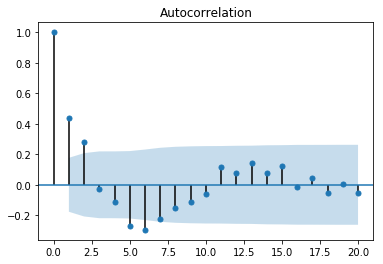

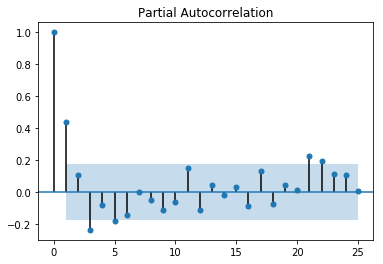

In [90]:
acf_plot = plot_acf(series, lags=20)
pacf_plot = plot_pacf(series, lags=25)

# Why use the ACF to determine the order of the MA model ?

Because if $k>q$ then $\rho_X(k) = 0$. Therefore, the last non-zero bar n the ACF plot gives the order of the MA model.

# Fit the MA model

**Remark :** With a MA(2) model, we can only predict two time periods ahead. Otherwise, it will just predict the average value $mu$.

In [91]:
# Train and test data
train_end = datetime(2019,12,30)
test_end = datetime(2020,1,1)

train_data = series[:train_end]
test_data = series[train_end + timedelta(days=1):test_end]

In [87]:
model = ARIMA(train_data, order=(0,0,2))

In [88]:
model_fit = model.fit()
print(model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  121
Model:                     ARMA(0, 2)   Log Likelihood                -153.028
Method:                       css-mle   S.D. of innovations              0.856
Date:                Mon, 11 Nov 2024   AIC                            314.056
Time:                        15:52:22   BIC                            325.239
Sample:                    09-01-2019   HQIC                           318.597
                         - 12-30-2019                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         50.3298      0.139    362.562      0.000      50.058      50.602
ma.L1.y        0.4351      0.090      4.827      0.000       0.258       0.612
ma.L2.y        0.3586      0.085      4.236      0.0

# Predictions

Prediction model :

$$
\hat{X}_t = 50.1420 + 0.4468 \epsilon_{t-1} + 0.3421\epsilon_{t-2}
$$

With $\epsilon_{t} \sim \mathcal{N}(0,1)$

Mean Absolute Percentage Error : 0.008966405363443985
Root Mean Squared Error : 0.5092746615016466


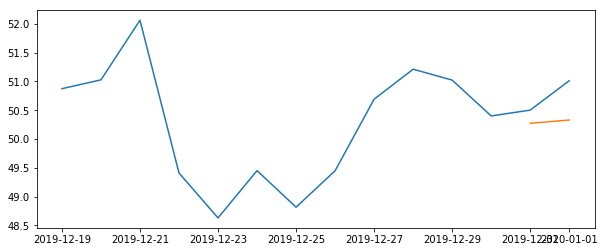

In [89]:
start_pred = test_data.index[0]
end_pred = test_data.index[-1]

predictions = model_fit.predict(start=start_pred, end=end_pred)

plt.figure(figsize=(10,4))

plt.plot(series[-14:], label='Data')
plt.plot(predictions, label='Predictions')

residuals = predictions - test_data

# Precision evaluation metrics
print('Mean Absolute Percentage Error :', np.mean(abs(residuals/test_data))) # Mean absolute percentage error
print('Root Mean Squared Error :', np.sqrt(np.mean(residuals**2)))  # Root mean squared error